In [1]:
%matplotlib notebook

import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict

from mpl_toolkits import mplot3d

# Using library numpy-stl to handle STL files (https://pypi.python.org/pypi/numpy-stl)
from stl import mesh

# Observations

This problem sounds easy at first glance, but a number of edge cases make it tricky.
1. The "house" shape, which should need no support at all because the sloped roof holds up the top edge.
2. Anything touching the build plate, which doesn't need support.
3. A Cube, where the top edges don't need support, but the top face does.
4. A stalagtite, where the tip vertex needs support, but none of the edges or faces do.

# Plan

The basic approach I want to take is to determine whether a face/edge/vertex needs support purely by looking at the local properties of that feature and the things around it. We'll see if that works.

An alternative approach would be to build a directed graph indicating what things hold each other up, and reason about which edges need to be added to make it have a root.

An STL file contains information about faces, edges, and vertices.
## Faces
A face needs support when its is "flat" i.e. its normal vectors is close to the gravity vector. A cross product to get the normal vector, followed by a dot product with the gravity vector, makes computing that really easy.

Precomputation of $cos(\theta)$ should make the whole computation quite cheap.

## Edges
In addition to edges surrounding faces needing support, some edges themselves need to be supported, even if both of their neighboring faces are fine. An example is a horizontal edge connecting two faces in a "V" configuration. Notice that this edge requires support, while the inverse case (a peak) doesn't.

In this case, we are looking for an edge that is mostly horizontal (dot product again), and where neither (none) of its neighboring faces is sufficiently below it to support it (using their normals). Depending on what's next in the pipeline, it may or may not matter whether an edge adjacent to a supported face is supported or not.

This assumes that your FDM machine cannot perform bridging operations.

## Vertices

In addition to the cases above, a vertex needs support if none of its neighboring vertices are sufficiently below it. (i.e. tip of a [stalagtite](http://media.gettyimages.com/photos/stalactites-and-stalagmites-in-jenolan-caves-picture-id595906719?s=612x612) )

# Implementation

In [2]:
down = np.array([0, 0, -1])
theta = np.deg2rad(45)

epsilon = 0.000001 # A very small number, to deal with floating point rounding.

def isMostlyUp(vec):
    """
    Returns true if the provided 3-vector is pointning within theta of up
    """
    cosangle = np.dot(vec, down) / (np.linalg.norm(down) * np.linalg.norm(vec))
    costheta = np.cos(theta)
    
    return cosangle >= costheta

def isMostlyVertical(vec):
    """
    Returns true if the provided 3-vector is pointning within theta of up or down
    """
    cosangle = np.dot(vec, down) / (np.linalg.norm(down) * np.linalg.norm(vec))
    costheta = np.cos(theta)
    
    return cosangle >= costheta or cosangle <= -costheta

tests = [[0,0,1],
        [0,1,2],
        [0,2,1],
        [0,-1,-3],
        [0,4,0],
        ]

for t in tests:
    print t, isMostlyVertical(t)

[0, 0, 1] True
[0, 1, 2] True
[0, 2, 1] False
[0, -1, -3] True
[0, 4, 0] False


In [3]:
def almostEqual(v1, v2):
    """
    Checks whether two values (numbers, vectors, or arrays) are equal within epsilon.
    """
    return np.max(np.abs(v2 - v1)) <= epsilon

In [4]:
def isOnBuildPlate(point):
    # The build plate is assumed to be a infinite plane perpendicular 
    # to gravity, passing through the point (0, 0, 0)
    return almostEqual(np.dot(point, down), 0)

In [5]:
def faceNeedsSupport(face):
    """
    face is a list of three vertices
    """
    p1, p2, p3 = np.array(face)
    normal = np.cross(p2-p1, p3-p1)
    
    if not isMostlyVertical(normal):
        # The face itself is vertical
        return False
    else:
        # The face is horizontal
        for p in face:
            if not isOnBuildPlate(p):
                # At least one vertex is not on the build plate
                return True
        # All vertices on build plate
        return False

In [6]:
def edgeNeedsSupport(endpoints, faces):
    """endpoints is list of two points, 
    faces is a list of arbitrarily many neighboring faces, given as triples of points"""
    
    p1, p2 = np.array(endpoints)
    
    if isMostlyVertical(p2-p1):
        # Vertical edges are supported by their endpoint
        return False
    
    if isOnBuildPlate(p1) and isOnBuildPlate(p2):
        # This edge is supported by the build plate
        return False        
    
    # Check for a face that supports this edge
    for face in faces:
        # We need to check whether the face is "below" the edge.
        # Note that this can happen even if the third point on the edge is above 
        # both of the points on the edge.
        
        otherPoints = [p for p in face if (not almostEqual(p, p1) and not almostEqual(p, p2))]
        if len(otherPoints) != 1:
            raise Exception('Face provided not containing given edge')
            
        p3 = np.array(otherPoints[0])
        
        # The easiest way to check this is to which side of this edge the face is on
        # is to compute the cross product of this edge's vector with the vector to the third point,
        # as well as the cross product of this edge's vector and gravity. If those vectors are within 
        # +-90 degrees of each other, the face is below the edge.
        
        faceNormal = np.cross((p2-p1), (p3-p1))
        gravityNormal = np.cross((p2-p1), down)
        
#         faceNormal /= np.linalg.norm(faceNormal)
#         gravityNormal /= np.linalg.norm(gravityNormal)
        
        if np.dot(faceNormal, gravityNormal) > 0:
            # The face is "below" this edge
            if not faceNeedsSupport(face):
                # The face can support this edge
                return False
            
            
    return True
    

In [7]:
def vertexNeedsSupport(point, edges):
    """
    Takes as input:
        - A point Vector3
        - A list of edges connected to this point, given as pairs of points
    """
    point = np.array(point)
    edges = np.array(edges)
    
    if isOnBuildPlate(point):
        return False
    
    for edge in edges:
        otherPoints = [p for p in edge if not almostEqual(p, point)]
        if len(otherPoints) != 1:
            raise Exception('Edge provided not containing given vertex')
        other = otherPoints[0]
        
        # Check whether this point is mostly above the current edge
        if isMostlyUp(point - other):
            # This vertex is at the top of the provided edge, and so supported.
            return False
        
    return True


In [8]:
np.sort(np.array([[1,2,3],[1,4,2]]),axis=0)

array([[1, 2, 2],
       [1, 4, 3]])

# Using it

In [9]:
model = mesh.Mesh.from_file('tests/cube.stl')
faces = model.vectors

vertices = defaultdict(set) # Map of vertex (tuple) to set of neighboring edges, each represented as a sorted tuple
edges = defaultdict(set) # Map of edge (sorted tuple) to set of neighboring faces, each represented as a sorted tuple
# faces = set() # set of faces (sorted tuples)

def add_vertex(vertex, edge):
    edge = tuple(sorted(edge))
    if vertex not in edge:
        raise Exception('Vertex must be in edge')
    vertices[vertex].add(edge)
    
def add_edge(edge, face):
    edge = tuple(sorted(edge))
    face = tuple(sorted(face))
    
    p1, p2 = edge
    add_vertex(p1, edge)
    add_vertex(p2, edge)
    
    edges[edge].add(face)
    
def add_face(face):
    face = tuple(sorted(face))
    
    p1, p2, p3 = face
    add_edge((p1, p2), face)
    add_edge((p2, p3), face)
    add_edge((p1, p3), face)
    

faces[:2]

for face in faces:
    add_face(map(tuple, face))

In [10]:
for face in faces:
    print faceNeedsSupport(face)
    
# There should be 2, the top ones

False
False
False
False
False
False
True
True
False
False
False
False


In [11]:
for edge, fs in edges.iteritems():
    print edgeNeedsSupport(edge, fs)
    
# There should just be one (the top crease)

False
False
False
False
False
False
False
False
False
False
False
False
False
False
True
False
False
False


In [117]:
for vertex, es in vertices.iteritems():
    print vertexNeedsSupport(vertex, list(es))
# Should be none

True
True
False
False
False
False
True
True


In [13]:
print len(faces) # Should be 6: 2 per face of the cube
print len(edges) # Should be 18: 12 + 6 extra
print len(vertices) # Should be 8: the corners

12
18
8


In [14]:
sorted(map(tuple, faces[0]))

[(0.0, -20.0, 0.0), (0.0, 0.0, 0.0), (20.0, 0.0, 0.0)]

## Rendering

<IPython.core.display.Javascript object>


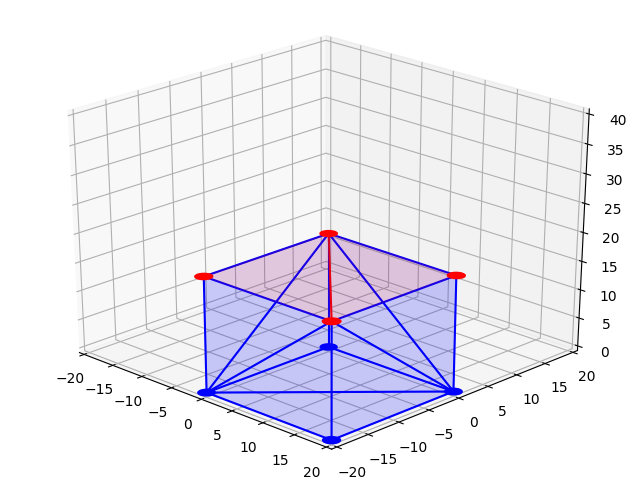

In [116]:
from matplotlib.patches import Circle

# Create a new plot
figure = plt.figure()
axes = mplot3d.Axes3D(figure)

axes.set_xlim(-20,20)
axes.set_ylim(-20,20)
axes.set_zlim(0,40)

red = (1,0,0)
blue = (0,0,1)

theseedges = edges.keys()

linecollection = mplot3d.art3d.Line3DCollection(theseedges, colors=edgecolors, alpha=1)
linecollection.set_color([red if edgeNeedsSupport(e, edges[e]) else blue for e in theseedges])

facecollection = mplot3d.art3d.Poly3DCollection(faces, alpha=0.1)
facecollection.set_color([red if faceNeedsSupport(f) else blue for f in faces])

for p, es in vertices.iteritems():
    circle = Circle(p[0:2], 1)
    circle.set_color(red if vertexNeedsSupport(p, list(es)) else blue)
    axes.add_patch(circle)
    mplot3d.art3d.pathpatch_2d_to_3d(circle, z=p[2])

axes.add_collection3d(linecollection)
axes.add_collection3d(facecollection)
# axes.add_collection3d(pointcollection)


## STL library examples (reference)

<IPython.core.display.Javascript object>


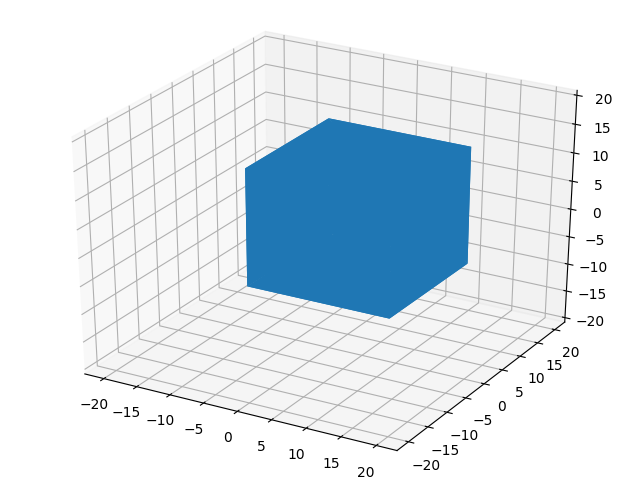

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:10: DeprecationWarning: Non-string object detected for the array ordering. Please pass in 'C', 'F', 'A', or 'K' instead
  # Remove the CWD from sys.path while we load stuff.


In [25]:
# Create a new plot
figure = plt.figure()
axes = mplot3d.Axes3D(figure)

# Load the STL files and add the vectors to the plot
your_mesh = mesh.Mesh.from_file('tests/cube.stl')
axes.add_collection3d(mplot3d.art3d.Poly3DCollection(your_mesh.vectors, alpha=0.5))

# Auto scale to the mesh size
scale = your_mesh.points.flatten(-1)
axes.auto_scale_xyz(scale, scale, scale)


In [17]:
your_mesh.vectors

array([[[ 20.,   0.,   0.],
        [  0., -20.,   0.],
        [  0.,   0.,   0.]],

       [[  0., -20.,   0.],
        [ 20.,   0.,   0.],
        [ 20., -20.,   0.]],

       [[ 20., -20.,  20.],
        [  0., -20.,   0.],
        [ 20., -20.,   0.]],

       [[  0., -20.,   0.],
        [ 20., -20.,  20.],
        [  0., -20.,  20.]],

       [[ 20.,   0.,   0.],
        [ 20., -20.,  20.],
        [ 20., -20.,   0.]],

       [[ 20., -20.,  20.],
        [ 20.,   0.,   0.],
        [ 20.,   0.,  20.]],

       [[ 20., -20.,  20.],
        [  0.,   0.,  20.],
        [  0., -20.,  20.]],

       [[  0.,   0.,  20.],
        [ 20., -20.,  20.],
        [ 20.,   0.,  20.]],

       [[  0.,   0.,  20.],
        [  0., -20.,   0.],
        [  0., -20.,  20.]],

       [[  0., -20.,   0.],
        [  0.,   0.,  20.],
        [  0.,   0.,   0.]],

       [[  0.,   0.,  20.],
        [ 20.,   0.,   0.],
        [  0.,   0.,   0.]],

       [[ 20.,   0.,   0.],
        [  0.,   0.,  20.]